<a href="https://colab.research.google.com/github/pgurazada/causal_inference/blob/master/10_DML_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q dowhy econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 35.5 MB/s eta 0:00:00


In [2]:
import graphviz

import numpy as np
import pandas as pd
import networkx as nx

from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from dowhy import CausalModel
from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML

from econml.dr import DRLearner, SparseLinearDRLearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

# Example 1

## Data

In [3]:
# Train set
earnings_interaction_train = pd.read_csv(r'ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'ml_earnings_interaction_test.csv')

In [4]:
earnings_interaction_train.sample(5)

,age,python_proficiency,took_a_course,earnings
320,22,0.447066,True,135924.0
2145,27,0.191121,True,148652.0
450,26,0.025926,True,144685.0
520,20,0.093395,False,114095.0
2841,27,0.248739,False,138546.0


In [5]:
earnings_interaction_test.sample(5)

,age,python_proficiency,took_a_course,true_effect
37,22,0.614050,True,13071.0
99,19,0.453541,True,12268.0
31,19,0.893535,True,14468.0
25,25,0.619170,True,13096.0
0,30,0.223877,True,11120.0


## Estimating Causal Models

In [6]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [7]:
# Instantiate the CausalModel
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

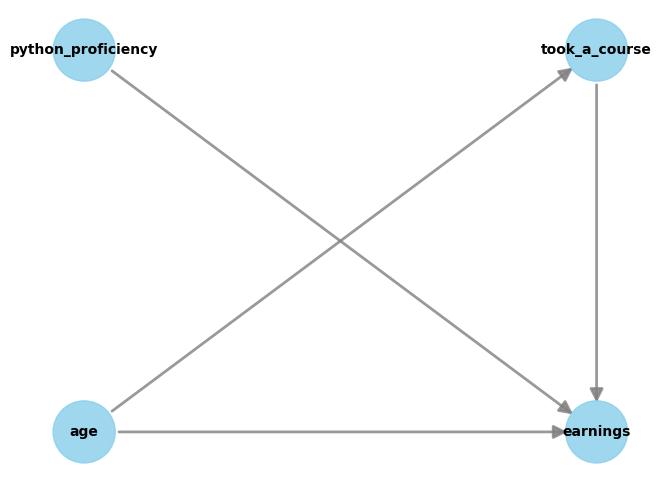

In [8]:
model.view_model()

In [9]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Linear DML-Learner

In [10]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True
        },
        'fit_params': {}
    }
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 4
[LightGBM] [Info] Start training from score 143006.796000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [11]:
estimate.cate_estimates.mean()

12638.29734981854

DML with folds

In [12]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    }
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 4
[LightGBM] [Info] Start training from score 143374.235200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

In [13]:
estimate.cate_estimates.mean()

12627.069764948037

DML with cross validation

In [14]:
# Define wrapped CV models
model_y = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    },
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

In [15]:
model_t = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    },
    cv=10,
    n_jobs=-1,
    scoring='accuracy'
)

In [16]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': model_y,
            'model_t': model_t,
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    }
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Number of positive: 1476, number of negative: 2274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393600 -> initscore=-0.432205
[LightGBM] [Info] Start training from score -0.432205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [17]:
estimate.cate_estimates.mean()

12540.76606248727